## CM50268 / CM30322

## Coursework 1

# Exploring Bayesian Linear Regression

**Total Marks 30 (30% of overall unit grade).**

*Submission deadline: 8pm, Friday 7th March. Please submit your completed notebook file in Moodle.*

## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code. 
Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`

There is also one place where you are asked to enter explanatory text (in Task 3b).
Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**. 
The workbook you submit must be an `.ipynb` file, which is saved into the 
directory you're running Jupyter; alternatively you can download it from the menu above using 
`File -> Download`. Remember to save your work regularly
("Save Notebook" in the File menu, the icon of a floppy disk, or Ctrl-S);
the version you submit should have all code blocks showing the results (if any) 
of execution below them.

### Important!

**You should take care to avoid any suggestion of plagiarism in your submission.**
There is helpful information on "Academic Integrity" and, specifically, how to avoid plagiarism
on the University website: https://www.bath.ac.uk/library/help/infoguides/plagiarism.html

For this coursework, **you may use library code from specific sources only**: `numpy`, `scipy` and `matplotlib`. If you wish to use any alternative libraries, you are welcome to request this via the *Moodle* discussion forum.

Note that **the use of Generative AI is not permitted**.

## Overview of Coursework Tasks

This coursework focuses on implementing some of the requisite calculations and manipulations 
for applying Bayesian linear regression models as covered in Lectures 3&ndash;6.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculation and exploitation of error-bars (the predictive standard deviation),
- ... some presentation of results.

The data is synthetic, derived from a "Gaussian" radial basis function (RBF) model. The model we will attempt
to fit is similarly a linearly-weighted set of "Gaussian" (RBF) basis functions. Our model, however,
will incorporate basis functions of different radius (width) than the generator. (In the second coursework
we will attempt to re-estimate this radius parameter.)
 
The training data has an important feature: *there are no observations from one
particular region of the data space*. 
One of the aims of the exercise (Task 3) is to see how this aspect 
impacts on the uncertainty of the model predictions.

There are three principal tasks, with varying marks. In summary here:

**Task 1:** Fit various Gaussian RBF-based linear models to the training data
using penalised least-squares (PLS), and visualise the results. (5 marks)

**Task 2:** Replicate the example "Occam's Razor" slide from Lecture 4
using the model and data here &mdash; that is, compute the train, validation and test set errors,
plus the marginal likelihood (the red dashed curve in the example slide), 
over a range of $\lambda$ (or $\alpha$) values. Identify and plot the best posterior mean model. (18 marks)

**Task 3:** Visualise the error-bars (predictive variance) alongside the best posterior mean model.
Explore how those error-bars might be usefully exploited in a real-world system where there is risk and reward.
(7 marks)

### "Advanced" Marks
**Please note!** Across assignments, there may be a small number of marks which are designated "advanced" marks.
These apply to sub-tasks which might be a little more technically demanding, and can optionally be skipped without interrupting the "flow" of an assignment.
In this particular coursework there are two "advanced" marks, and even if you ignore those questions, you can still obtain over 93% of the marks overall.

## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules.
**You may need to add some of your own `import` statements here too, although note the
restrictions specified earlier regarding library code use.**

In addition, there is a setup module `setup_cw1` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for 
varying data sets,
- the function `error_rms` to simply calculate errors for a given target values 
$y$ and corresponding model output $f$,
- a function `plot_regression` to consistently plot data sets and curves etc,
- a couple of helper functions to optionally enable neat tabulation of outputs: `tabulate_locals` and
`tabulate_neatly`.

*You don't need to use the plotting and tabulation code* if you don't want to!

We also set some "constants" below: data set sizes and the generative noise standard deviation, 
which we fix at $\sigma=0.15$ for the entire exercise.

In [109]:
# Standard modules
import numpy as np

# Lab-specific support module
import setup_cw1 as setup

# Add your own imports here
import scipy
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatterExponent

# Data specification
N_train_full = 50  # Before any data is "masked out"
N_val_full = N_train_full
N_test = 1000
#
sigma = 0.15
sigma_2 = sigma ** 2

### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=32$ (originally 50, but 18 points are "masked out") with added Gaussian random noise
with standard deviation $\sigma=0.15$,
- validation set of size $N_{val}=32$, again with added noise $\sigma=0.15$,
- test set of size $N_{test}=1000$ with **no noise** and **covers the full data space**.

A feature of the test set is that *it will include data from the region where there is no training data*.

**Note:** we assume for now that $\sigma$ is known and fixed.

In [110]:
# Data - create generator instance, and synthesise 3 sets from
# an RBF model using 10 basis functions and no bias
#
radius_gen = 1.00  # Generative basis radius or width
train_mask = [3, 6]  # The range where there will be no data
generator = setup.DataGenerator(r=radius_gen, noise=sigma, mask=train_mask)
#
x_train, y_train = generator.get_data('TRAIN', N_train_full, mask_out=True)
x_val, y_val = generator.get_data('VALIDATION', N_val_full, mask_out=True)
x_test, y_test = generator.get_data('TEST', N_test, mask_out=False)

N_train = 32
Empirical σ_train = 0.150
N_validation = 32
Empirical σ_validation = 0.150
N_test = 1000


### Generate Basis for Linear Model
For our linear model, we use as many functions as data points (a "complete" basis), 
comprising $N-1$ equally-spaced Gaussian functions of the form:
 
$$\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}.$$
 
plus a fixed "bias" or "offset". (The synthesised data was based on a different set of basis functions and did *not* use a bias.)

The model basis function 'width' (length scale) parameter $r$ is set to 0.75. (This is narrower than the width
used to generate the data.)

If we call `evaluate` on the basis generator, 
we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains 
the output of each basis function on each data point respectively: that is, 
$\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains 
simply a fixed value of one. 

For the training set, this matrix $\mathbf{\Phi}$ will be $32 \times 32$,
whereas for the test set it will be $1000 \times 32$.

For illustration, the data and the underlying "ground-truth" are shown below, 
with basis functions overlaid. Some local variables are also tabulated, just to summarise the key variables.
(This can also be a useful "sanity check" in longer notebooks.)

Local Variables Check

Variable,Value
N_train,32
N_val,32
N_test,1000
sigma,0.15
sigma_2,0.0225
M,32
radius_gen,1
radius_model,0.75


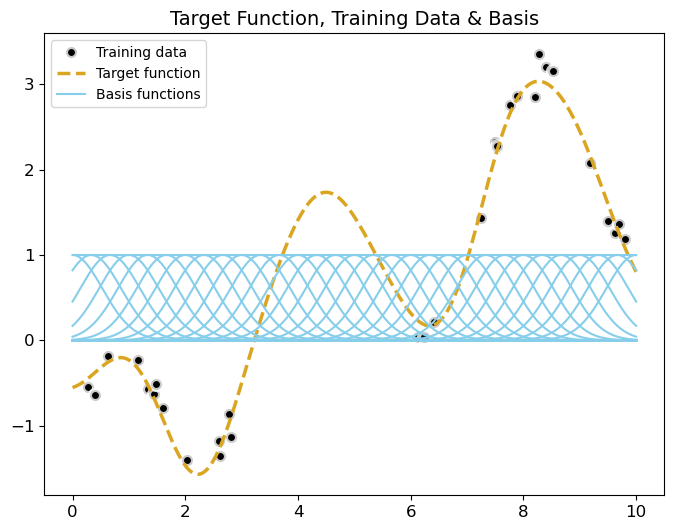

In [111]:
# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
N_train = len(x_train)
N_val = len(x_val)
radius_model = radius_gen * 0.75
centres = np.linspace(generator.x_min, generator.x_max, N_train - 1)
basis = setup.RBFGenerator(centres, width=radius_model, bias=True)
M = basis.M
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)
#
interest = ["N_train", "N_val", "N_test", "sigma", "sigma_2",
            "M", "radius_gen", "radius_model"]
setup.tabulate_locals(locals(), interest)
#
setup.plot_regression(x_train, y_train, x_test, y_test, basis_test=PHI_test,
                      title="Target Function, Training Data & Basis", legend=True)


# Task 1: Fitting Penalised Least Squares Models
**5 marks for this task in total.**

## Task 1a
*2 marks overall*

#### Implement penalised least squares fitting (2 marks)

Write a function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `y_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

You may find the functions `np.linalg.lstsq` and/or `np.linalg.inv` applicable.

For maximum marks, the ideal solution will treat $\lambda=0$ case differently to $\lambda>0$.

In [112]:
## FIT_PLS
##
def fit_pls(PHI, y, lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    if np.isclose(lam,0):
        w = np.linalg.lstsq(PHI,y,rcond=None)[0]
    else:
        w = np.linalg.inv(PHI.T @ PHI + lam * np.eye(PHI.shape[1])) @ PHI.T @ y
    return w


## Task 1b
*3 marks overall*

#### Implement a prediction assessor (1 mark)

Write a function `assess_predictor` that does the following:

- fits the model to the data for a given value of lambda using `fit_pls`
- computes the fitted model's predictions `f_test` on the *test set* (you will need to multiply the
  relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)
- plots the training data, target function (test data) and the predictions (using `plot_regression`)
- returns the RMS training and test errors

#### Visualise fits for three values of λ (1 mark)

Using the function you have just written, add a few lines of code in the second cell below
to plot three graphs for values of $\lambda$ in \[ 1e-9, 0.05, 25\]. In each graph (appropriately labelled by $\lambda$),
your `assess_predictor` function should show:
- the training data (`x_train` and `y_train` as points)
- the underlying generating function (by plotting `x_test` and `y_test` as a line)
- your fitted function `f_test` at points `x_test` (as a line)

#### Tabulate PLS errors (1 mark)

Output a table, showing the RMS error for both train and test sets for all three values of $\lambda$.

The supplied function `plot_regression` should do nearly all the plotting work for you, but please add an informative title.
(You do not need to show the basis.)

You should find that the first $\lambda$ value over-fits, the second is "about right" 
(but only where there is data!) and the third under-fits.

In [129]:
## FITTING & GRAPHING FUNCTION
#  
def assess_predictor(model_rbf, lamb, x__train, y__train, x__test, y__test):
    #
    #### **** YOUR CODE HERE **** ####
    #
    PHI_train = model_rbf.evaluate(x__train)
    PHI_test = model_rbf.evaluate(x__test)
    w = fit_pls(PHI_train, y__train, lamb)
    f_train = PHI_train @ w
    f_test = PHI_test @ w

    error_train = setup.error_rms(y__train, f_train)
    error_test = setup.error_rms(y__test, f_test)
    setup.plot_regression(x__train, y__train, x__test, y__test, y_predict=f_test, title=f"Target Function, Training Data & Prediction, λ = {lamb}", legend=True)#, ylim=(-2,4))
    return error_train, error_test


λ Value,Train error,Test error
1e-09,4.04334e-06,1.25047e+10
0.05,0.107982,0.573423
25,0.890223,0.897683


None


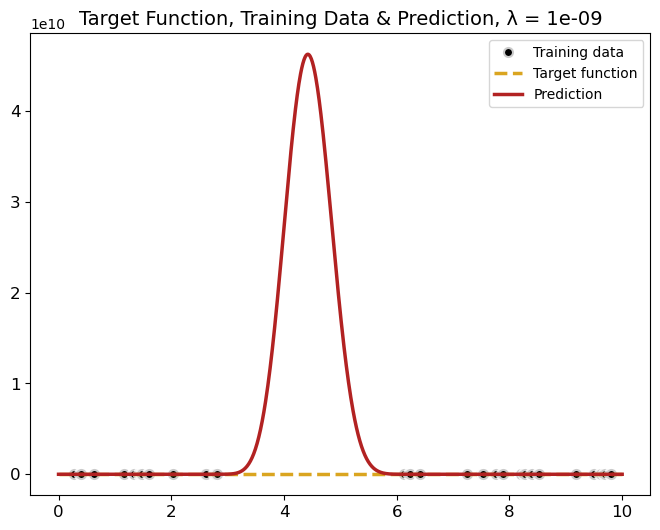

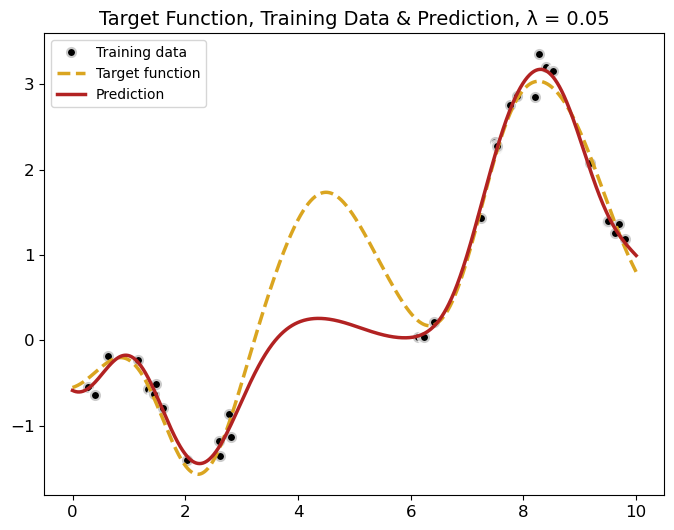

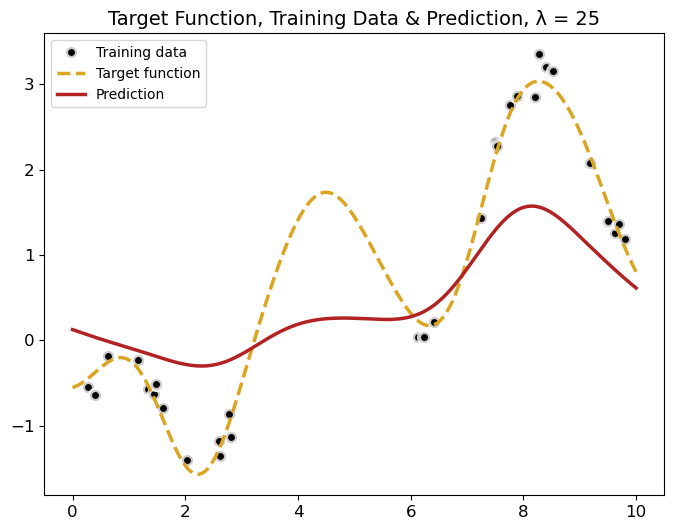

In [130]:
# Output your table here
#
#### **** YOUR CODE HERE **** ####
#
# Add code to plot the requested graphs for lambda_value=1e-9, 0.05 and 25 respectively,
# while simultaneously compiling a table of errors
#
#### **** YOUR CODE HERE **** ####

errors = []
lambda_val=[1e-9,0.05,25]

for lamb in lambda_val:
    error_train, error_test = assess_predictor(basis, lamb, x_train, y_train, x_test, y_test)
    d={}
    d["λ Value"] = lamb
    d["Train error"] = error_train
    d["Test error"] = error_test
    errors.append(d)
print(setup.tabulate_neatly(errors, headers="keys", colalign=("center", "center", "center")))


# Task 2 : Bayesian Modelling & the Marginal Likelihood
**18 marks for this task in total.**

## Task 2a
*3 marks overall*

#### Compute the posterior distribution (3 marks)

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and 
covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with 
basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and 
$\sigma^2$.

Verify the consistency of your posterior code with `fit_pls` by comparing 
the outputs `w` and `Mu` (they should be the same), remembering to take account of the fact 
that $\alpha \equiv \lambda/\sigma^2$.

As well as defining your `compute_posterior` function below, 
append a few lines of code underneath 
which show your consistency check for $\lambda=0.01$.

In [115]:
## POSTERIOR
##
def compute_posterior(PHI, y, alpha, sigma_squared):
    #
    #### **** YOUR CODE HERE **** ####
    #
    mu = np.linalg.inv(PHI.T @ PHI + sigma_squared*alpha * np.eye(np.shape(PHI)[1])) @ (PHI.T @ y)
    cov = sigma_squared*np.linalg.inv(PHI.T @ PHI + sigma_squared*alpha * np.eye(np.shape(PHI)[1]))
    return mu,cov

# check consistency
#
#### **** YOUR CODE HERE **** ###
#
lambda_values=[1e-9,0.05,0.25, 0.01]
for l in lambda_values:
    lam=l
    alpha=lam/(sigma_2)
    w= fit_pls(PHI_train, y_train, lam)
    mu,cov=compute_posterior(PHI_train, y_train, alpha, sigma_2)
    if np.allclose(mu,w):
        print(f"Consistency test passed for λ = {l}")
    else:
        print(f"Consistency test failed for λ = {l}")
#should match in all of them except when lambda=0, since it's not penalised least squares.

Consistency test failed for λ = 1e-09
Consistency test passed for λ = 0.05
Consistency test passed for λ = 0.25
Consistency test passed for λ = 0.01


## Task 2b
*3 marks overall*

#### Compute the marginal likelihood (2 marks)

Write a function `compute_log_marginal` to compute the *logarithm* of
the marginal likelihood for the Bayesian linear regression model with basis matrix 
$\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

The necessary equation(s) may be found in the slides / notes corresponding to Lecture 4
("Marginalisation & Occam's Razor"):
 
$$p(\mathbf{y}|\alpha, \sigma^2) = 
(2 \pi)^{-\frac{N}{2}} |\sigma^2 \mathbf{I} + 
\alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top}|^{-\frac{1}{2}} 
\exp\{ -\frac{1}{2} \mathbf{y}^{\top} 
(\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top})^{-1} \mathbf{y}  \}.$$

**Important:** for numerical reasons, when computing the logarithm of a probability density,
always compute the logarithmic form directly (whether in terms of your own Python code or
via a library such as `stats.multivariate_normal.logpdf`).
**Never** compute the pdf and then call `np.log`!

In practice, you should not have numerical issues using 
`stats.multivariate_normal.logpdf` (this can happen if you experiment 
with larger data sets, in which case you may wish to look at the `allow_singular` argument.)
You can also code up your own calculation "manually" without use of library code (in two different ways).


#### Woodbury Identity (advanced) (1 mark)

**Advanced**: As an alternative to `stats.multivariate_normal.logpdf`, there is a more
robust way of calculating the marginal likelihood directly, which you may wish to explore
if you are confident with linear algebra and matrix identities.

**Note:** this advanced mark is
in addition to that above &mdash; you should also provide a "standard" implementation of `compute_log_marginal`
to obtain full marks for Task 2b.

The "straightforward" way to calculate the marginal likelihood is to compute 
the NxN covariance matrix and then call the `logpdf` function.
As a result, this will imply an expensive, and potentially numerically troublesome, 
inversion of an N x N matrix (inside `logpdf`). This works OK, but in general we can do better.

To gain the extra advanced mark, you would need to re-phrase the straightforward way
in terms of the inversion, and determinant, of an M x M matrix. 
Since matrix inversion scales cubically with the matrix size (M or N),
this is computationally a lot cheaper in the usual case where N >> M,
and more importantly, numerically much more robust.

Slightly confusingly in this exercise here, N = M, so it doesn't appear 
to make any difference. However, in more general modelling situations, 
M would be a lot smaller than N, so it would be an important thing to do. 
In terms of re-phrasing the inversion as M x M, you may wish to look at 
the "Woodbury Identity", which crops up regularly in data science.
There is an equivalent identity for determinants too.

In [116]:
## MARGINAL LIKELIHOOD
##
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    sigma=s2*np.identity(np.shape(PHI)[0])+(1/alph)* PHI @ PHI.T
    det=np.linalg.slogdet(sigma)[1]
    inverse=np.linalg.pinv(sigma)
    log_marg=-1/2*(np.shape(PHI)[0]*np.log(2*np.pi)+det+y.T@inverse@y)
    return log_marg.item()
# now using scipy
def compute_log_marginal2(PHI, y, alph, s2):
    sigma=s2*np.identity(np.shape(PHI)[0])+(1/alph)* PHI @ PHI.T
    mean= np.zeros(np.shape(PHI)[0])
    log_marg=scipy.stats.multivariate_normal.logpdf(y.flatten(),mean,sigma)
    return log_marg
#should be the same
alpha=0.01/sigma_2
print(compute_log_marginal(PHI_train, y_train, alpha, sigma_2))
print(compute_log_marginal2(PHI_train, y_train, alpha, sigma_2))

-11.576855825889153
-11.576855825889822


In [117]:
## MARGINAL LIKELIHOOD (ADVANCED VERSION - OPTIONAL)
##
def compute_log_marginal_advanced(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    n=np.shape(PHI)[0]
    m=np.shape(PHI)[1]
    o= alph*np.identity(np.shape(PHI)[1])+1/s2 * PHI.T @ PHI
    o_inv= np.linalg.inv(o)
    log_det=np.linalg.slogdet(o)[1]+n*np.log(s2)-np.log(alph)*m

    log_marg=-1/2*(n*np.log(2*np.pi)+log_det+y.T @ (1/s2 *np.identity(n)-1/s2 * PHI @ o_inv @ PHI.T *1/s2) @ y)
    return log_marg.item()
alpha=0.01/sigma_2
compute_log_marginal_advanced(PHI_train, y_train, alpha, sigma_2)

-11.576855825916944

## Task 2c
*9 marks overall*

In the cells below, write some code to produce a similar figure to that below (taken from the lecture) for the
Gaussian RBF basis and the data set(s) defined above.

<img src="slide15.png" alt="Slide 15 from Lecture 5"
 style="width: 512px;margin-left:16mm;"/>

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, 
you should do the following:

#### Compute the relevant errors (1 mark)

Compute the train, validation and test set errors for
the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms`
in 'setup_cw1' to calculate the error).

#### Compute the (negative log) marginal likelihood (2 marks)

Also compute the *negative* log marginal likelihood using the function just written,
for the training data set *and a data set which combines both the training and validation data*.

#### Plot the curves (3 marks)

Plot **all these curves on the same graph**, noting that the vertical axis for
the errors is different for that of the negative log marginal likelihood (see hint below),
and the horizontal axis, while shared, requires careful translation between λ and α.

Credit will be given for a clearly rendered graph, with sensible axis scaling.

Note that it's *not* essential to plot the vertical lines which connect the curves.

#### Find minimum points and tabulate test errors (2 marks)

In addition to plotting the graph, add code to compute,
and output (using `print` or `tabulate_neatly`), the *test error* corresponding to
the minimum point on:
- the test error curve itself,
- the validation curve,
- the negative marginal likelihood curve (on the training data),
- the negative marginal likelihood curve (on combined training and validation data).

#### Find the best α value (1 mark)

Calculate a value of `best_alpha`, which is the value of $\alpha$ that minimises
the negative marginal likelihood curve (on *combined* training and validation data).

### Notes

For easiest interpretation, please define your $\lambda$ range 
logarithmically (**base 10**) and **fix the range between -6 and 4**.

First use `np.linspace(begin,end,steps)` to create equally spaced values `v`, 
then specify `lam = 10**v`. Please fix the `steps` value as 100.

You should find that your graph has a similar qualitative form to the above figure, 
although there will be one extra curve and the test error curve will be higher above the
training/validation curves.

### Hints

- You can create a new $y$-axis on the same plot, which shares the $x$-axis, 
using `plt.gca().twinx()`.
- Remember that $\alpha=\lambda/\sigma^2$. If you don't rescale appropriately, 
the marginal likelihood curve will not be correctly aligned with the error curves 
and your minimum point will be incorrect! 😟

In [118]:
#
#### **** YOUR CODE HERE **** ####
#

# Calculate the error for the train, test and validation sets and
# the negative log marginal-likelihood on the train set and combined
# train and validation sets ... all for a range of lambda

v = np.linspace(-6, 4, 100)
lam = 10**v
train_errors = []
val_errors = []
test_errors = []
neg_log_marg_train = []
neg_log_marg_train_val = []
PHI_combine = np.vstack((PHI_train, PHI_val))
y_combine = np.concatenate((y_train, y_val))

for l in lam:
    w = fit_pls(PHI_train, y_train, l)
    train_errors.append(setup.error_rms(y_train, PHI_train @ w))
    val_errors.append(setup.error_rms(y_val, PHI_val @ w))
    test_errors.append(setup.error_rms(y_test, PHI_test @ w))
    #We get p(t|lamda/sigma_2,sigma_2) so that we can graph them in the same x axis
    alpha = l / sigma_2
    neg_log_marg_train.append(-compute_log_marginal_advanced(PHI_train, y_train, alpha, sigma_2))
    neg_log_marg_train_val.append(-compute_log_marginal_advanced(PHI_combine, y_combine, alpha, sigma_2))


Errors at minimum points

Point,Test Error at that point
Minimum test error,0.571599
Min validation error,0.588476
Min negative marginal likelihood (train data),0.574858
Min negative marginal likelihood (train and validation data),0.572497


Best α value: 2.484804525560988


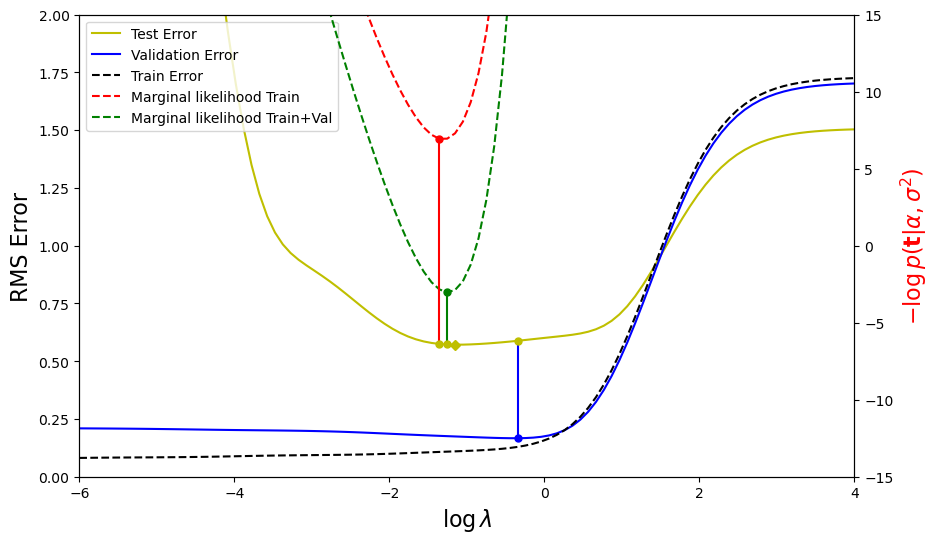

In [119]:
# PLEASE PLOT ALL THE CURVES IN THE SAME FIGURE

# Print out (or tabulate) the test error corresponds to the minimum point on (1) the test error curve itself,
# (2) the validation curve, and (3, 4) the negative marginal-likelihood curves.
#
#### **** YOUR PLOTTING CODE HERE **** ####
#
min_test_error_l = np.argmin(test_errors)
min_val_error_l = np.argmin(val_errors)
min_neg_log_marginal_train_l = np.argmin(neg_log_marg_train)
min_neg_log_marginal_train_val_l = np.argmin(neg_log_marg_train_val)

min_test_error = test_errors[min_test_error_l]
min_test_at_min_val = test_errors[min_val_error_l]
min_test_at_min_nlm_train = test_errors[min_neg_log_marginal_train_l]
min_test_at_min_nlm_train_val = test_errors[min_neg_log_marginal_train_val_l]

table= [
    ["Minimum test error", min_test_error],
    ["Min validation error", min_test_at_min_val],
    ["Min negative marginal likelihood (train data)", min_test_at_min_nlm_train],
    ["Min negative marginal likelihood (train and validation data)", min_test_at_min_nlm_train_val]
]
setup.tabulate_neatly(table, headers=["Point", "Test Error at that point"], title="Errors at minimum points",colalign=("center","center"))

best_alpha = lam[min_neg_log_marginal_train_val_l] / sigma_2
print(f"Best α value: {best_alpha}")

fig,ax1 = plt.subplots(figsize=(10,6))
#plot RMS
ax1.set_xscale("log")
ax1.plot(lam, test_errors, "y-", label="Test Error")
ax1.plot(lam, val_errors,"b-", label="Validation Error")
ax1.plot(lam, train_errors, "k--", label="Train Error")
ax1.set_xlabel(r'$\log{\lambda}$', fontsize= 16)
ax1.set_ylabel("RMS Error", fontsize= 16)
ax1.set_ylim(0, 2)
ax1.set_xlim([10**-6,10**4])
#plot the minimum points
ax1.plot(lam[min_test_error_l], min_test_error, marker="D", markersize=5, color="y")
ax1.plot(lam[min_val_error_l], val_errors[min_val_error_l], marker="o", markersize=5, color="b")
ax1.vlines(lam[min_val_error_l], val_errors[min_val_error_l], test_errors[min_val_error_l], colors="b", linestyles="-")
ax1.plot(lam[min_val_error_l], test_errors[min_val_error_l], marker="o", markersize=5, color="y")


ax1.xaxis.set_major_formatter(LogFormatterExponent())

ax2= plt.gca().twinx()
#plot the negative log marginal likelihood
ax2.plot(lam,neg_log_marg_train, "r--", label="Marginal likelihood Train")
ax2.plot(lam,neg_log_marg_train_val, "g--", label="Marginal likelihood Train+Val")
#vertical lines (if we change the ylim, we need to change the *15-15)
ax2.plot(lam[min_neg_log_marginal_train_l], neg_log_marg_train[min_neg_log_marginal_train_l], marker="o", markersize=5, color="r")
ax2.vlines(lam[min_neg_log_marginal_train_l], neg_log_marg_train[min_neg_log_marginal_train_l], test_errors[min_neg_log_marginal_train_l]*15-15, colors="r", linestyles="-")
ax2.plot(lam[min_neg_log_marginal_train_l], test_errors[min_neg_log_marginal_train_l]*15-15, marker="o", markersize=5, color="y")
ax2.plot(lam[min_neg_log_marginal_train_val_l], neg_log_marg_train_val[min_neg_log_marginal_train_val_l], marker="o", markersize=5, color="g")
ax2.vlines(lam[min_neg_log_marginal_train_val_l], neg_log_marg_train_val[min_neg_log_marginal_train_val_l], test_errors[min_neg_log_marginal_train_val_l]*15-15, colors="g", linestyles="-")
ax2.plot(lam[min_neg_log_marginal_train_val_l], test_errors[min_neg_log_marginal_train_val_l]*15-15, marker="o", markersize=5, color="y")

ax2.set_ylim(-15,15)
ax2.set_ylabel(r"$-\log{p(\mathbf{t}|\alpha,\sigma^2)}$", color="red", fontsize= 16)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,loc= "upper left")
plt.show()




## Task 2d
*3 marks overall*

#### Evaluate the posterior mean predictor (2 marks)

Using the best value of $\alpha$ according to the marginal likelihood as found in Task 2c 
above, call `compute_posterior` to find the posterior mean weight vector $\mu$ and 
use this to compute the posterior mean predictor at all the test points 
`x_test`. 

#### Visualise the predictor (1 mark)

Then, similar to Task 1b, using the `plot_regression` function, plot on the same axes:
1. the training data (`x_train` and `y_train` as points),
2. the underlying generating function (by plotting `x_test` and `y_test` as a line),
3. the posterior mean predictor function you just calculated.

You should find that the predictor is a pretty good fit to the underlying 
generating function *where there was data in the training set*. 
We can't expect the model to make good predictions in the "gap" 
where it has not seen any training data (unless it gets lucky!).

In [120]:
# Code to calculate posterior mean weights and corresponding predictor
#### **** YOUR CODE HERE **** ####
mu,cov = compute_posterior(PHI_train, y_train, best_alpha, sigma_2)
post_mean_pred = PHI_test @ mu



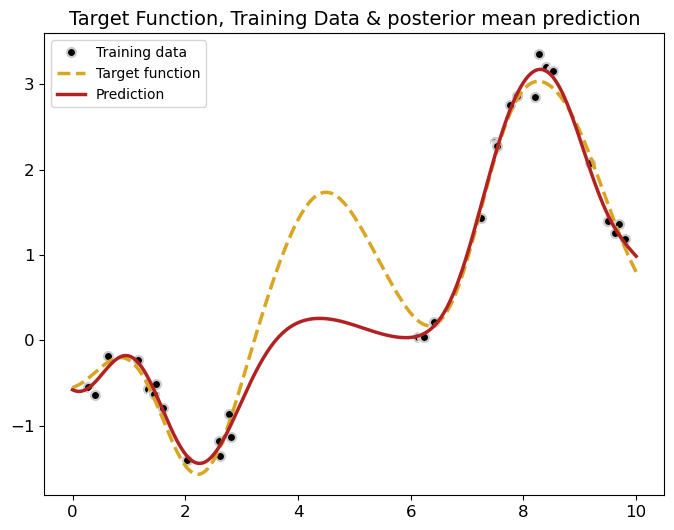

In [121]:
# Visualise the predictor
#
#### **** YOUR PLOTTING CODE HERE **** ####
#
setup.plot_regression(x_train, y_train, x_test, y_test, y_predict=post_mean_pred,title="Target Function, Training Data & posterior mean prediction", legend=True)


# Task 3: Predictive Variance and Error Bars <a name="task3"></a>
**7 marks for this task in total.**

## Task 3a
*2 marks overall*

#### Compute the predictive variance and then plot the "error-bars" (2 marks)

Remember that a "prediction" of $y_\ast$ at a particular $x_\ast$ in the Bayesian sense is not a single value, but actually a
*distribution* over possible values that a new datum $y_\ast$ (sampled at $x_\ast$) might take,
based on the model definition and the parameter settings. That
distribution encapsulates the inevitable uncertainty in prediction, taking account of both the data noise
variance (which can't be avoided) and the uncertainty in estimating the weights (which will decrease with more training data).
Given our model choices, we have a Gaussian predictive distribution at each $x$,
and the graph you plotted above (in Task 2d) shows just the *mean* of the distribution at each point.

Repeat the graph above (Task 2d), for the same "best" predictor, but this time also
compute the predictive variance at each point in `x_test`, and use these values to overlay 
"error bars" on the plot.

### Notes

The predictive variance can be computed from the posterior covariance matrix
$\mathbf{\Sigma}$ in conjunction with the `PHI_test` basis matrix, along with the noise variance $\sigma^2$.
To plot the "error bars", you will need to compute the predictive *standard deviation* at each test point &mdash;
in other words, the square-root of the predictive variance.

- By "error bars" we usually mean some chosen multiple of the predictive standard deviation; please
opt for +/- **one standard deviation** here,
- You'll need to compute this for every $x$ &mdash; you can do this with a loop, but there is also
an efficient way to do it with matrix and vector operations
- To compute the predictive variance at `x_test`, you'll need the matrix `PHI_test`,
- The matplotlib function `plt.fill_between` is a handy utility for plotting error bars, 
but you may also wish to look at the functionality in `plot_regression`,
- If your calculations are correct, you should expect to see much larger error bars in the gap
where there is no data.

In [122]:
# Compute the predictive variance
#
#### **** YOUR CODE HERE **** ####
mu,cov = compute_posterior(PHI_train, y_train, best_alpha, sigma_2)
post_mean_pred = (PHI_test @ mu)
post_cov = PHI_test @ cov @ PHI_test.T + sigma_2
pred_var = np.diag(post_cov)


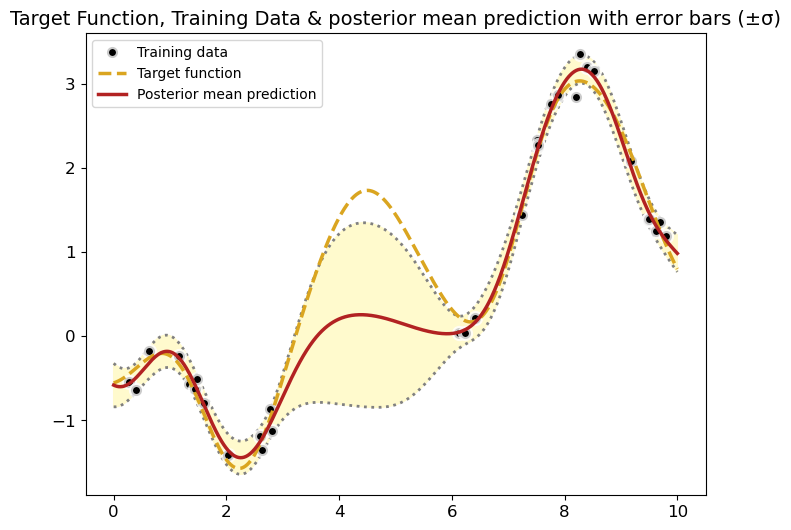

In [123]:
# Plot the error bars
#
#### **** YOUR PLOTTING CODE HERE **** ####
#

plotter = setup.Plotter()
plotter.bars(x_test, post_mean_pred.flatten()-np.sqrt(pred_var), post_mean_pred.flatten()+np.sqrt(pred_var))
plotter.plot("train", x_train, y_train, label="Training data")
plotter.plot("test", x_test, y_test, label="Target function")
plotter.plot("predict", x_test, post_mean_pred, label="Posterior mean prediction")
plotter.tidy(title="Target Function, Training Data & posterior mean prediction with error bars (±σ)", legend=True)

## Task 3b
*5 marks overall*

This is a more open-ended question, with an opportunity to think a little creatively.

Imagine you had built the above model for inclusion within some real-world system where 
it was desired to make accurate predictions at the 1,000 test points. For this exercise, you
can assume there is no data noise when deployed, and the only predictive uncertainty is due
to the weights of the trained model.

The "real-world system" is such that there are costs and rewards associated with each prediction:

- for each absolute error of `threshold=0.15` or less, the model is rewarded with £10
- for each absolute error of greater than `threshold`, there is a cost of £20

**Key feature of the "system":** *You may decline to make a prediction for a given data point*, based on the knowledge of $x$.
If you do decline to make a prediction, there is no cost (or reward).

### Devise an Algorithm Which Chooses When to Predict (and When to Decline)
*Without knowledge of the test set*, devise an algorithm that aims to maximise your *expected* earnings.
That is, an algorithm that decides, given an arbitrary $x$, whether to predict $y$ or whether to decline.
This can only be an approximate maximisation (remember, "all models are wrong"), but, given the model,
there is a principled way to make a decision whether to predict or decline, given the cost and reward
specification.

Specifically, where indicated in the below cells (and detailed further below), do the following four things:

1. Explain your approach
2. Implement your algorithm
3. Evaluate it and tabulate results
4. **Advanced:** Visualise its decision-making

#### Explain your algorithm (2 marks)

Write a short explanation of your approach in the "Explanation of Approach" markdown cell.

#### Implement your algorithm (1 mark)

Provide the necessary decision code for your algorithm in the first code cell below.

#### Evaluate your approach and tabulate some statistics (1 mark)

In the second code cell below, apply your algorithm to the 1,000 (noiseless) test points `x_test` and tabulate:

- The number of predictions (out of 1,000) made
- The number that were rewarded for being within threshold
- The number that were charged for being outside the threshold
- The percentage of predictions made that were rewarded
- Your total earnings

You should be able to make as much as £5,000 (or thereabouts, without cheating!).
If your algorithm is over-confident and makes too many predictions, you may do poorly due to incurring many costs. Alternatively, if your algorithm is too conservative and declines to predict too often, you may do poorly due to not earning enough rewards.

#### Visualise the operation of your algorithm (advanced) (1 mark)

**Advanced:** Plot a graph which illustrates where your algorithm chooses to predict and where it chooses to decline.
More specifically, you should show:
- the target function (test points `x_test` and `y_test` as a line)
- your predictor (posterior mean)
- the error-bars, but only where the algorithm chooses to predict, and in one particular colour of your choosing
- the error-bars, this time only where the algorithm chooses to decline, and in a different colour of your choosing
- a helpful legend
- Optionally: the training data


### Explanation of Approach (*Your Answer Here*)

The posterior predictor follows a gaussian distribution with mean $\mu$ and standard deviation $\sigma$. The absolute error being less than the threshold means that the real value $y$ needs to be in the interval $(\hat{y}-0.15,\hat{y}+0.15)$ where $\hat{y}=\mu$ is the prediction. As the predictor follows a gaussian distribution, the probability of the prediction being correct (the absolute error being less than the threshold) is:
$$P(\mu-0.15\leq y \leq \mu+0.15)=\Phi(\frac{0.15}{\sigma})-\Phi(\frac{-0.15}{\sigma})= 2\Phi(\frac{0.15}{\sigma})-1$$ 
where $\Phi$ is the CDF of the normal standard distribution.

Thus, the expected reward is:
$$\text{Expected Reward} = P(\text{correct prediction})\cdot \text{reward} - P(\text{incorrect prediction})\cdot \text{cost}$$
$$=\bigg(2\Phi(\frac{0.15}{\sigma})-1\bigg)\cdot 10 - \bigg(2-2\Phi(\frac{0.15}{\sigma})\bigg)\cdot 20$$
Then the predictor will only make a prediction when the expected reward is greater or equal than 0.

In [124]:
# Implement your algorithm here
#
# Use these fixed values
threshold = 0.15
reward_under = 10
cost_above = 20

#### **** YOUR ALGORITHM CODE HERE **** ####
def prediction_alg(model_rbf,x_train, y_train,x_val, y_val, x_test, y_test, best_alpha, sigma_2=0.15**2,threshold= 0.15, reward_under=10, cost_above=20):
    PHI_train = model_rbf.evaluate(x_train)
    PHI_val = model_rbf.evaluate(x_val)
    PHI_test = model_rbf.evaluate(x_test)

    #Find best alpha
    v = np.linspace(-6, 4, 100)
    lam = 10**v
    neg_log_marg_train_val = []
    PHI_combine = np.vstack((PHI_train, PHI_val))
    y_combine = np.concatenate((y_train, y_val))

    for l in lam:
        alpha = l / sigma_2
        neg_log_marg_train_val.append(-compute_log_marginal(PHI_combine, y_combine, alpha, sigma_2))
    min_neg_log_marginal_train_val_l = np.argmin(neg_log_marg_train_val)
    best_alpha = lam[min_neg_log_marginal_train_val_l] / sigma_2

    #compute posterior and calculate variance
    mu,cov = compute_posterior(PHI_train, y_train, best_alpha, sigma_2)
    post_mean_pred = (PHI_test @ mu)
    #we assume no data noise, only parameter uncertainity
    post_cov = PHI_test @ cov @ PHI_test.T
    pred_var = np.sqrt(np.diag(post_cov))

    #calculate probability of success and expected reward
    prob_success=2*scipy.stats.norm.cdf(threshold/pred_var)-1
    expected_reward=prob_success*reward_under-(1-prob_success)*cost_above
    rewards=0
    pred_count=0
    correct=0
    incorrect=0
    predicted_points=[]
    not_predicted_points=[]
    for i in range(len(x_test)):
        if expected_reward[i]>0:
            pred_count+=1
            predicted_points.append(i)
            if abs(post_mean_pred[i]-y_test[i])<threshold:
                correct+=1
                rewards+=reward_under
            else:
                incorrect+=1
                rewards-=cost_above
        else:
            not_predicted_points.append(i)
    return pred_count, correct, incorrect, rewards , (post_mean_pred,pred_var,predicted_points,not_predicted_points)


In [125]:
# Apply your algorithm to the test set, and tabulate the relevant statistics

#### **** YOUR TABULATION CODE HERE **** ####
#
model = basis = setup.RBFGenerator(centres, width=0.75, bias=True)
count,correct,incorrect,total_rewards, graph_things = prediction_alg(model,x_train, y_train,x_val, y_val, x_test, y_test, best_alpha, sigma_2,threshold, reward_under, cost_above)
table= [
    ["Number of predictions", count],
    ["Correct predictions", correct],
    ["Incorrect predictions", incorrect],
    ["Percentage of rewarded predictions", correct/count*100],
    ["Total earnings", total_rewards]
]
setup.tabulate_neatly(table, headers=[])


Number of predictions,618
Correct predictions,573
Incorrect predictions,45
Percentage of rewarded predictions,92.7184
Total earnings,4830


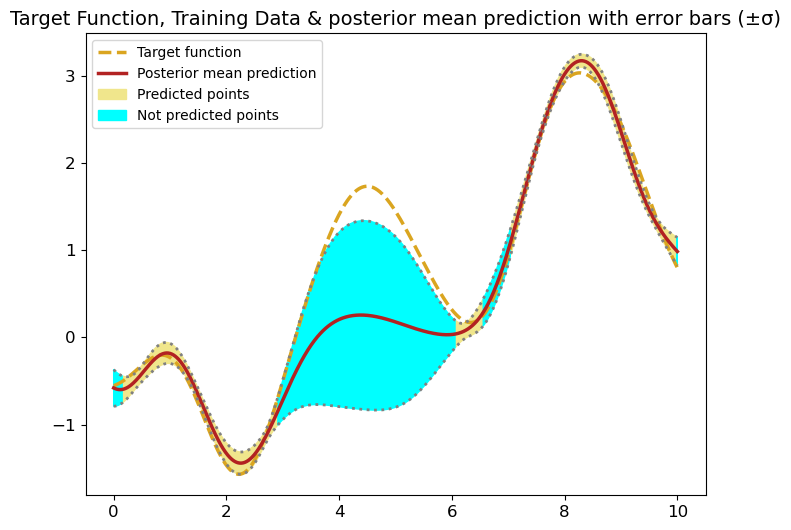

In [126]:
# Visualise your algorithm's decision-making (advanced / optional)

#### **** YOUR GRAPHING CODE HERE **** ####
#
post_mean_pred,pred_var,predicted_points,not_predicted_points = graph_things
plot_bar= np.zeros(len(x_test))
plot_bar[predicted_points]=1
not_plot_bar= np.zeros(len(x_test))
not_plot_bar[not_predicted_points]=1
plotter = setup.Plotter()
plotter.plot("test", x_test, y_test, label="Target function")
plotter.plot("predict", x_test, post_mean_pred, label="Posterior mean prediction")
# plotter.plot("train", x_train, y_train, label="Training data")
plt.fill_between(x_test.ravel(), post_mean_pred.flatten()-pred_var, post_mean_pred.flatten()+pred_var, where=plot_bar,linestyle= "", linewidth= 2.5, color= "khaki",label = "Predicted points")
plt.plot(x_test, post_mean_pred.flatten()-pred_var, marker = "", linestyle = ":", linewidth = 2, color = "Grey")
plt.plot(x_test, post_mean_pred.flatten()+pred_var, marker = "", linestyle = ":", linewidth = 2, color = "Grey")
plt.fill_between(x_test.ravel(), post_mean_pred.flatten()-pred_var, post_mean_pred.flatten()+pred_var, where=not_plot_bar,linestyle= "", linewidth= 2.5, color= "cyan",label = "Not predicted points")
plotter.tidy(title="Target Function, Training Data & posterior mean prediction with error bars (±σ)", legend=True)